# ELISA Concentration computation with 4 Parameter Logistic curve

This notebook computes the parameters for a 4 parameter logistic curve.\
It will also calculate concentration values for the sample values and save them in a predefined directory as a new excel file.\
As input a platereader excel file of an ELISA measurement (or other measurements in a 96 well format) is used.\
Standard values have to be part of the plate and will be used for the computation of the standard curve.

<span style="color:red"> Everything that needs to be filled out / should be interacted with is indicated in red.

### Background Info

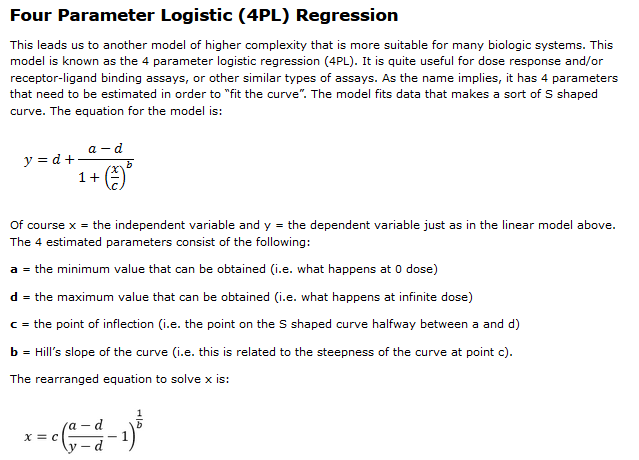
source: https://www.myassays.com/four-parameter-logistic-regression.html

### Importing relevant libraries

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy import optimize
from sklearn.metrics import r2_score
import pandas as pd
import seaborn as sns
import os
import datetime

# <span style="color:red"> Please enter info about your ELISA here:

- Fill out either A) or B) and skip the other one.
- If a standard curve without a serial dilution is used, make sure that the dilution factor in A) is set to 0.
- Fill out C in any case.

##### <span style="color:red"> A) FILL OUT WHEN THERE IS A SERIAL DILUTION FOR THE STANDARD 

In [2]:
# 1. Adjust value to wanted value
highest_standard_concentration = 20000 

# 2. Dilution factor in between standard values (e.g. 2 = dilution of 1:2 in between standard values)
dilution_factor = 2

# 3. Number of standard values
number_of_st_values = 12

#####  <span style="color:red">B) FILL OUT FOR CUSTOM STANDARD CONCENTRATIONS

In [3]:
# 1. Please check if dilution_factor = 0 in A) otherwise please set it to 0.

# 2. Pass standard concentrations in a list in decending order (like the example below)

st_concentration_list = [5, 3, 2, 1, 0.5, 0.25] 

##### <span style="color:red"> C) ALWAYS FILL OUT

##### Please read if you use this notebook for the first time:
Notes about filling out "C":
1. **Directory path to your excel file along with filename.xlsx** \
Example: r"R:\example_folder_1\example_folder_2\ELISA\Sample_file.xlsx" \
    <span style="color:red"> *The little "r" in the front is important!*


2. **Protein to detect** \
For example IFNy, IL2, IgG...


3. **Concentration dimension**\
Unit, like nmol/ml or pg/µl...


4. **Start of your 96 well plate**\
Take a look at the graphic + explantation below if you don't know what to insert here


5. **ODs measured for standard values**\
Example : st_ODs = [3.0768, 2.9526, 2.068, 1.0887, 0.5681, 0.2883, 0.1667, 0.0989, 0.0706, 0.0631, 0.0466, 0.0367] \
Alternatively set the list to 0 (st_ODs = 0) and pass the row name where your standard is pipetted (only applicable if all 12 values are filled) 


6. **Directory where you want to store your result**\
Example: output_directory = r"C:\Users\YourUsername\Desktop\ELISA results"\
Note: If you specify a directory that doesn't exist yet, it will be created!\
You can just use the examplary path from above, change "YourUsername" to your PC Username and the folder ELISA results\
will be created on your desktop.\
    <span style="color:red">*Please use the small "r" again in front of your directory name!*
        

7. **Example name**\
Name of the excel file with your results that will be created for you.\
Note: The filename will start with the current date automatically. No need to fill it in.\
Beware: If you create multiple result files on the same day without changing the file name, your data will be overwritten!
        
      
8. **Removing Outlier values**\
Clears outlier values if R squared is not below a certain treshold value. \
What actually happens: The highest standard values are dropped until R squared is below the treshold. \
In case your outlier is somewhere in the middle of your standard row, please use custom standard concentrations (In option section "B"). \
Toggle if this option should be used at all (1= yes, 0= no) and determine your preferred R squared value. Leave at 0.99 for default.

        
When you're done with filling everything in, press the "Restart Kernel and run everything" button.\
(Two arrow button)
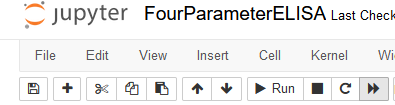

In [4]:
# 1. Directory path to your excel file along with filename.xlsx 
file_directory = r"Sample file.xlsx"

# 2. Protein to detect
protein = "IFNy"

# 3. Concentration dimension
dimension = "pg/ml"

# 4. Start of your 96 well plate: 
start_row = 68

# 5. ODs measured for standard values
st_ODs = 0

    # alternatively set the list to 0 (st_ODs = 0) and pass the row name where your standard is pipetted 
    # (only applicable if all 12 values are filled) 
    
st_OD_row = "H"

# 6. Directory where you want to store your result
output_directory = r"C:\Users\JaneDoe\Desktop\ELISA results"

# 7. Experiment name
experiment_name = "awesome ELISA"

# 8. Clear outlier values? (1= yes, 0= no)
clear_outlier = 0
r_squared_treshold = 0.99

Take a look at your ELISA excel file.\
Write down the row where the 96 well plate values you want to detect starts.\
In this example it would be "68":

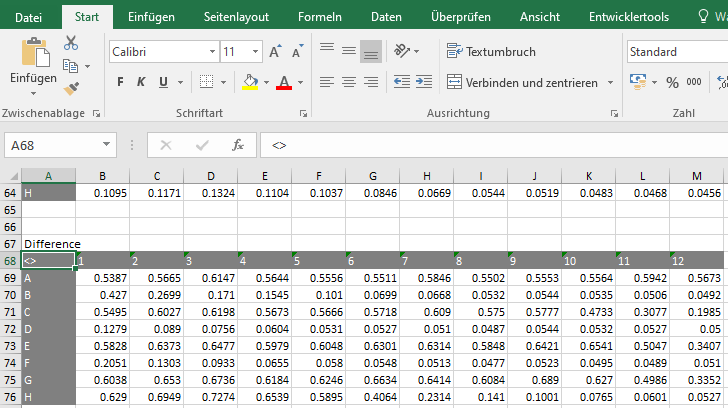

# <span style="color:red"> Please confirm your data

In [5]:
# importing the respective excel file
df = pd.read_excel(f"{file_directory}", header = None)

# extract the data from specific cells
cell_data = df.iloc[start_row:(start_row + 8), [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12]]

cell_data["row_names"] = ["A", "B", "C", "D", "E", "F", "G", "H"]

cell_data = cell_data.set_index("row_names")

print("Check if this is your raw data:")
cell_data.head(10)

Check if this is your raw data:


,1,2,3,4,5,6,7,8,9,10,11,12
row_names,,,,,,,,,,,,
A,0.5387,0.5665,0.6147,0.5644,0.5556,0.5511,0.5846,0.5502,0.5553,0.5564,0.5942,0.5673
B,0.427,0.2699,0.1710,0.1545,0.101,0.0699,0.0668,0.0532,0.0544,0.0535,0.0506,0.0492
C,0.5495,0.6027,0.6198,0.5673,0.5666,0.5718,0.6090,0.5750,0.5777,0.4733,0.3077,0.1985
D,0.1279,0.0890,0.0756,0.0604,0.0531,0.0527,0.0510,0.0487,0.0544,0.0532,0.0527,0.0500
E,0.5828,0.6373,0.6477,0.5979,0.6048,0.6301,0.6314,0.5848,0.6421,0.6541,0.5047,0.3407
F,0.2051,0.1303,0.0933,0.0655,0.058,0.0548,0.0513,0.0477,0.0523,0.0495,0.0489,0.0510
G,0.6038,0.6530,0.6736,0.6184,0.6246,0.6634,0.6414,0.6084,0.6890,0.6270,0.4986,0.3352
H,0.629,0.6949,0.7274,0.6539,0.5895,0.4064,0.2314,0.1410,0.1001,0.0765,0.0601,0.0527


In [6]:
if st_ODs == 0:
    alternative_st_ODs = cell_data.loc[st_OD_row]
    print("Check if these are your standard values:\n", alternative_st_ODs)
else:
        print("Check if these are your standard values: \n", st_ODs)
    

Check if these are your standard values:
 1      0.629
2     0.6949
3     0.7274
4     0.6539
5     0.5895
6     0.4064
7     0.2314
8      0.141
9     0.1001
10    0.0765
11    0.0601
12    0.0527
Name: H, dtype: object


### Computation of standard values

In [7]:
current_standard = highest_standard_concentration    # highest standard concentration
st_values = []                                       # list of standard concentrations

if dilution_factor == 0:
    st_values = st_concentration_list
else: 
    for i in range(number_of_st_values):
        if len(st_values) == 0:
            st_values.append(current_standard)
        else: 
            st_values.append(current_standard/dilution_factor)
            current_standard = current_standard/dilution_factor   

In [8]:
print(f"Standard concentrations used: \n{st_values}")

Standard concentrations used: 
[20000, 10000.0, 5000.0, 2500.0, 1250.0, 625.0, 312.5, 156.25, 78.125, 39.0625, 19.53125, 9.765625]


### Curve fitting

In [9]:
# Using standard concentrations as x-values
x = st_values  

# ODs of standard curve for y-values
if st_ODs == 0:
    st_ODs = list(alternative_st_ODs)
    
y = st_ODs  

def FourPL(x, a, b, c, d):
    '''Determines the "y" variable by inserting the already determined x, a, b, c, d parameters of a four parameter logistic curve.
    Background info to 4PL regression: https://www.myassays.com/four-parameter-logistic-regression.html
    
    args:
    x = list / array of standard concentration values
    a = minimum parameter
    b = inflection point parameter
    c = hills slope of the curve (=steepness at point b) parameter
    d = maximum parameter
    
    returns:
    computed OD value (y)
    '''
    return d+(a-d)/(1+ (x/c)**b) 

#### Computation of 4PL parameters a, b ,c, d with the help of x and y standard values ####
parameters_optimal, parameters_cov = optimize.curve_fit(FourPL, x, y, p0=[y[-1], 1, 1, y[0]]) #cov = covariance; p0 = initial values for curve fit

a = parameters_optimal[0] # min
b = parameters_optimal[1] # inflection point
c = parameters_optimal[2] # hills slope of the curve (=steepness at point b)
d = parameters_optimal[3] # max
###########################################################################################

# Used to model standard curve
x_model = np.linspace(min(x), max(x)+100000, 1000) 
y_model = FourPL(x_model, a, b, c, d) 

# Compute R squared value
y_predicted = FourPL(x, a, b, c, d)
r_squared = r2_score(y, y_predicted)

# Removing highest standard values and refitting curve, if r_squared is too low (only executed if specified above)

number_of_removed_values = 0

if clear_outlier == 1:
    while r_squared < r_squared_treshold:
        x = x[1:]
        y = y[1:]
        parameters_optimal, parameters_cov = optimize.curve_fit(FourPL, x, y, p0=[y[-1], 1, 1, y[0]])
        
        a = parameters_optimal[0] # min
        b = parameters_optimal[1] # inflection point
        c = parameters_optimal[2] # hills slope of the curve (=steepness at point b)
        d = parameters_optimal[3] # max
    
        # Compute R squared value
        y_predicted = FourPL(x, a, b, c, d)
        r_squared = r2_score(y, y_predicted)
    
        number_of_removed_values = number_of_removed_values + 1

C:\Users\Tina\AppData\Local\Temp\ipykernel_7052\2142742875.py:24: RuntimeWarning: invalid value encountered in power
  return d+(a-d)/(1+ (x/c)**b)


### Standard curve

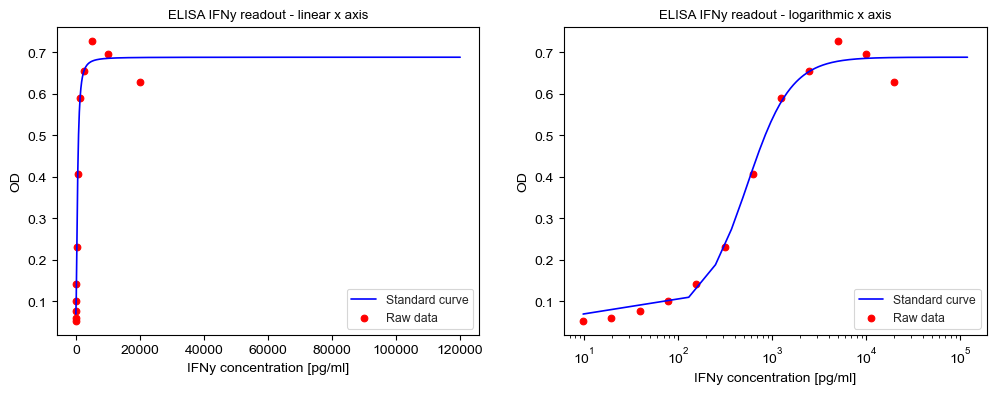

Standard curve parameters:
a = 0.06895775179898733  min value 
b =  1.858997050027041  inflection point 
c =  540.6564182968067  steepness at point b 
d =  0.6881844749106268  max value

R squared = 0.9918016789769005
Number of standard values not used (removed the highest standard concentration values) : 0


In [10]:
# Create a figure with two subplots (1 row, 2 columns)
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
sns.set_style("white")
sns.set_context("paper")

# Plot in the first subplot with a linear x-axis
axes[0].plot(x_model, y_model, label="Standard curve", color="blue")
axes[0].scatter(x, y, color="red", label="Raw data")
axes[0].set_title(f"ELISA {protein} readout - linear x axis")
axes[0].set_xlabel(f"{protein} concentration [{dimension}]")
axes[0].set_ylabel("OD")
axes[0].legend(loc="lower right")


# Plot in the second subplot with a logarithmic x-axis
axes[1].plot(x_model, y_model, label="Standard curve", color="blue")
axes[1].scatter(x, y, color="red", label="Raw data")
axes[1].set_title(f"ELISA {protein} readout - logarithmic x axis")
axes[1].set_xlabel(f"{protein} concentration [{dimension}]")
axes[1].set_ylabel("OD")
axes[1].set_xscale("log")
axes[1].legend(loc="lower right")

# Show the plots
plt.show()

# Print curve parameters and R squared
print("Standard curve parameters:\na =", a, " min value", 
      "\nb = ", b, " inflection point", 
      "\nc = ", c, " steepness at point b", 
      "\nd = ", d, " max value" "\n") 

print(f"R squared = {r_squared}")
print(f"Number of standard values not used (removed the highest standard concentration values) : {number_of_removed_values}")

Note that both graphs show the same values. The only difference is the representation:\
x-axis linear vs x-axis logarithmic

# Determination of sample concentrations

In [11]:
def OD_to_concentration(y, a=a, b=b, c=c, d=d):
    ''' Will compute x value (= concentration) from y value (= OD). 
    Global variables a, b, c and d are accessed from the previously computed 4 parameter logistic standard curve.
    Alternatively parameters can be passed manually.
    
    args:
    y = OD
    a = minimum parameter
    b = inflection point parameter
    c = hills slope of the curve (=steepness at point b) parameter
    d = maximum parameter
    
    returns:
    concentration value (x)
    '''
    x = c * (((a - d)/(y-d))-1)**(1/b)
    
    return x

# Example with OD = 0.3:
y = 0.6038
x = OD_to_concentration(y)

print(x)

1459.8793516527721


In [12]:
for index, row in cell_data.iterrows():
    cell_data.loc[index] = pd.to_numeric(row, errors='coerce')

output = cell_data.applymap(OD_to_concentration)

C:\Users\Tina\AppData\Local\Temp\ipykernel_7052\1681203339.py:16: RuntimeWarning: invalid value encountered in double_scalars
  x = c * (((a - d)/(y-d))-1)**(1/b)


In [13]:
# Rounding values to 2 digits after comma
output = output.applymap(lambda x: round(x, 2))

# Filling NaNs with out of limit text
output = output.fillna("OUT OF LIMIT")

print("Determined concentrations:")
output.head(12)

Determined concentrations:


,1,2,3,4,5,6,7,8,9,10,11,12
row_names,,,,,,,,,,,,
A,1000.95,1153.22,1589.8,1140.06,1088.17,1063.48,1281.99,1058.68,1086.49,1092.68,1364.31,1158.32
B,640.63,364.46,225.82,201.94,113.11,16.5,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT
C,1054.97,1448.14,1660.8,1158.32,1153.86,1187.93,1518.57,1210.01,1229.34,759.64,420.77,264.4
D,161.01,86.93,47.42,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT
E,1267.77,1980.07,2261.15,1399.38,1470.75,1831.4,1856.15,1283.59,2097.93,2495.17,860.96,473.68
F,273.56,164.88,96.88,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT,OUT OF LIMIT
G,1459.88,2450.41,4009.33,1640.55,1735.19,2986.89,2079.62,1511.52,OUT OF LIMIT,1775.59,839.55,464.55
H,1811.10,OUT OF LIMIT,OUT OF LIMIT,2486.87,1322.56,595.71,310.02,181.66,111.3,50.82,OUT OF LIMIT,OUT OF LIMIT


Values that are "OUT OF LIMIT" cannot be determined, as they are not within standard curve borders.\
Please adjust your standard curve or dilute your samples so that your values stay within the limits.\


You could also consider using a linear curve and exclude samples that are not in the linear range
\
Here are your original OD-values and the limit values to check again:

In [14]:
print("Original values:")

cell_data.head(12)

Original values:


,1,2,3,4,5,6,7,8,9,10,11,12
row_names,,,,,,,,,,,,
A,0.5387,0.5665,0.6147,0.5644,0.5556,0.5511,0.5846,0.5502,0.5553,0.5564,0.5942,0.5673
B,0.427,0.2699,0.1710,0.1545,0.101,0.0699,0.0668,0.0532,0.0544,0.0535,0.0506,0.0492
C,0.5495,0.6027,0.6198,0.5673,0.5666,0.5718,0.6090,0.5750,0.5777,0.4733,0.3077,0.1985
D,0.1279,0.0890,0.0756,0.0604,0.0531,0.0527,0.0510,0.0487,0.0544,0.0532,0.0527,0.0500
E,0.5828,0.6373,0.6477,0.5979,0.6048,0.6301,0.6314,0.5848,0.6421,0.6541,0.5047,0.3407
F,0.2051,0.1303,0.0933,0.0655,0.058,0.0548,0.0513,0.0477,0.0523,0.0495,0.0489,0.0510
G,0.6038,0.6530,0.6736,0.6184,0.6246,0.6634,0.6414,0.6084,0.6890,0.6270,0.4986,0.3352
H,0.629,0.6949,0.7274,0.6539,0.5895,0.4064,0.2314,0.1410,0.1001,0.0765,0.0601,0.0527


In [15]:
print(f"Minimum OD: {a}\nMaximum OD: {d}")

Minimum OD: 0.06895775179898733
Maximum OD: 0.6881844749106268


# Transfering outcomes to excel file

In [16]:
current_date = datetime.date.today() 
date_str = current_date.strftime("%Y-%m-%d")

if not os.path.exists(output_directory):
    try:
        os.makedirs(output_directory)
    except OSError as e:
        print(f"Error creating the directory.")
    else:
        print(f"Directory '{output_directory}' created successfully")
  
file_name = os.path.join(output_directory, f"{date_str} {experiment_name} 4PL curve.xlsx")
output.to_excel(file_name)

Error creating the directory.


OSError: Cannot save file into a non-existent directory: 'C:\Users\JaneDoe\Desktop\ELISA results'

You're done! Your data was saved to the previously specified directory. \
Please save a screenshot of your standard curve (under "Standard curve") and your curve parameters if needed.